# Import packages

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import scipy 

In [2]:
import rpy2.rinterface_lib.callbacks

In [3]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [4]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [5]:
from rpy2.robjects import pandas2ri
import anndata2ri

In [6]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Data Import

In [7]:
adata = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/cluster_integrated_with_DESC.h5ad")

In [8]:
adata.layers['raw_counts'] = scipy.sparse.csr_matrix.todense(adata.layers['raw_counts'])

In [9]:
adata.X = adata.layers['raw_counts']

In [10]:
adata.raw = adata

# Clustree 

In [11]:
data_clus = adata.obs[['desc_0.2','desc_0.3','desc_0.4','desc_0.5','desc_0.6','desc_0.7','desc_0.8','desc_0.9','desc_1.0','desc_1.2']]

In [12]:
data_clus.columns = ['desc_r2_clusters','desc_r3_clusters', 'desc_r4_clusters','desc_r5_clusters', 'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters','desc_r9_clusters','desc_r10_clusters','desc_r12_clusters']

In [13]:
data_clus.to_csv("/home/lugli/spuccio/Projects/Tmp/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/home/lugli/spuccio/Projects/Tmp/temp.csv",index_col=0,header=0)

In [14]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

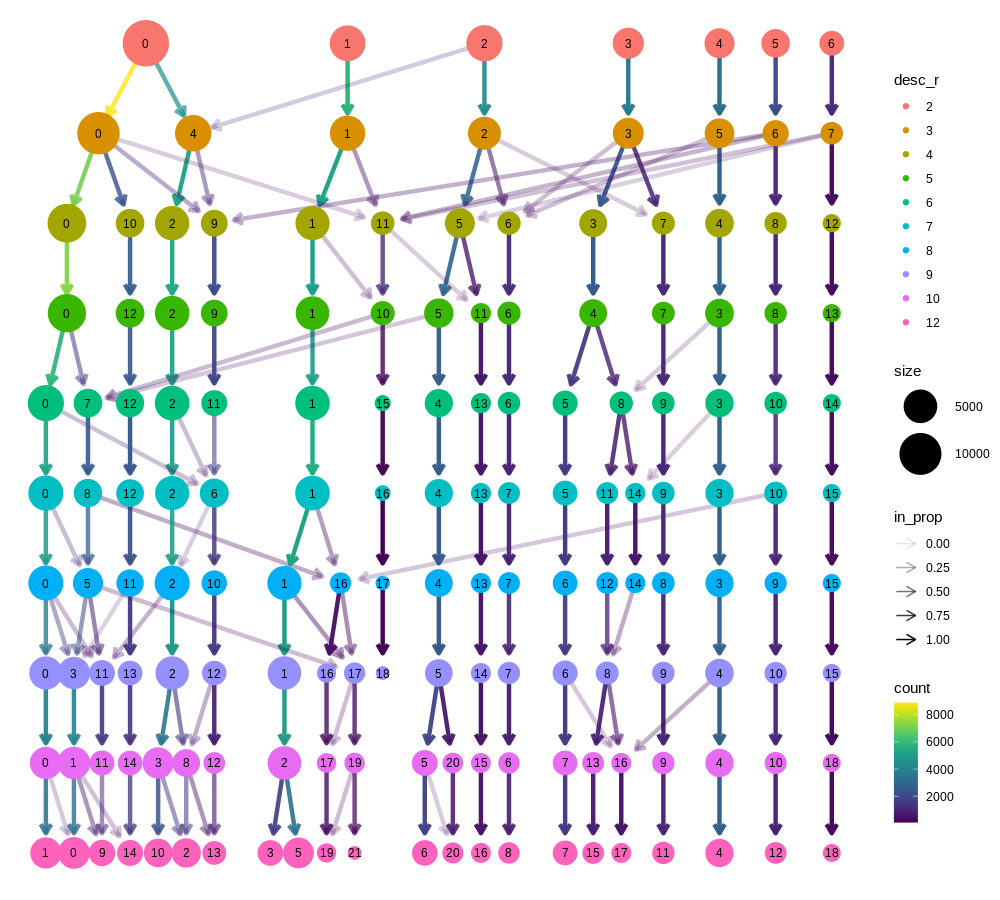

In [15]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

In [16]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Compute Umap

In [17]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb',n_neighbors=10, n_pcs=30)
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [18]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.5)]

In [19]:
run_vis(adata)

2023-10-03 12:12:11.148111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2023-10-03 12:12:11.148132: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
%matplotlib inline

# Plot cluster 

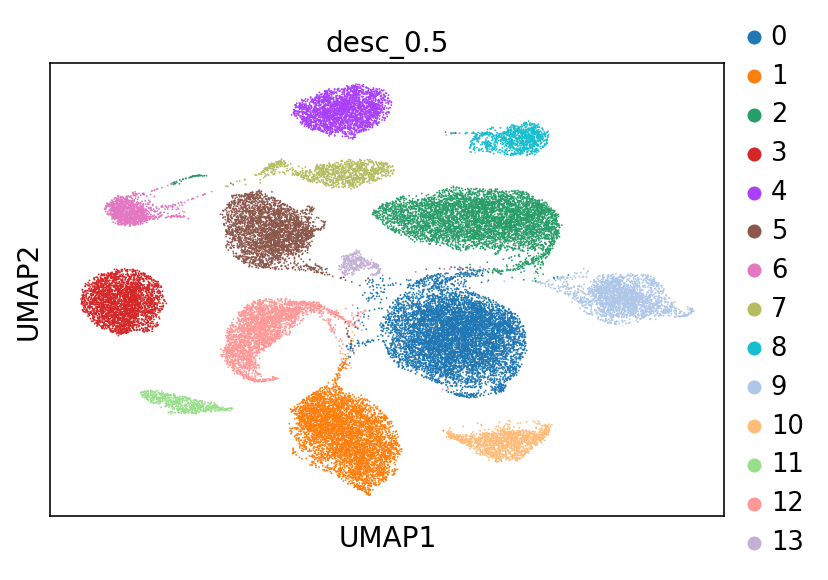

In [21]:
sc.pl.umap(adata, color=['desc_0.5'],color_map=mymap)

In [22]:
adata = adata[adata.obs['predicted_doublets'].isin([False]),:]

# Clusters Fraction

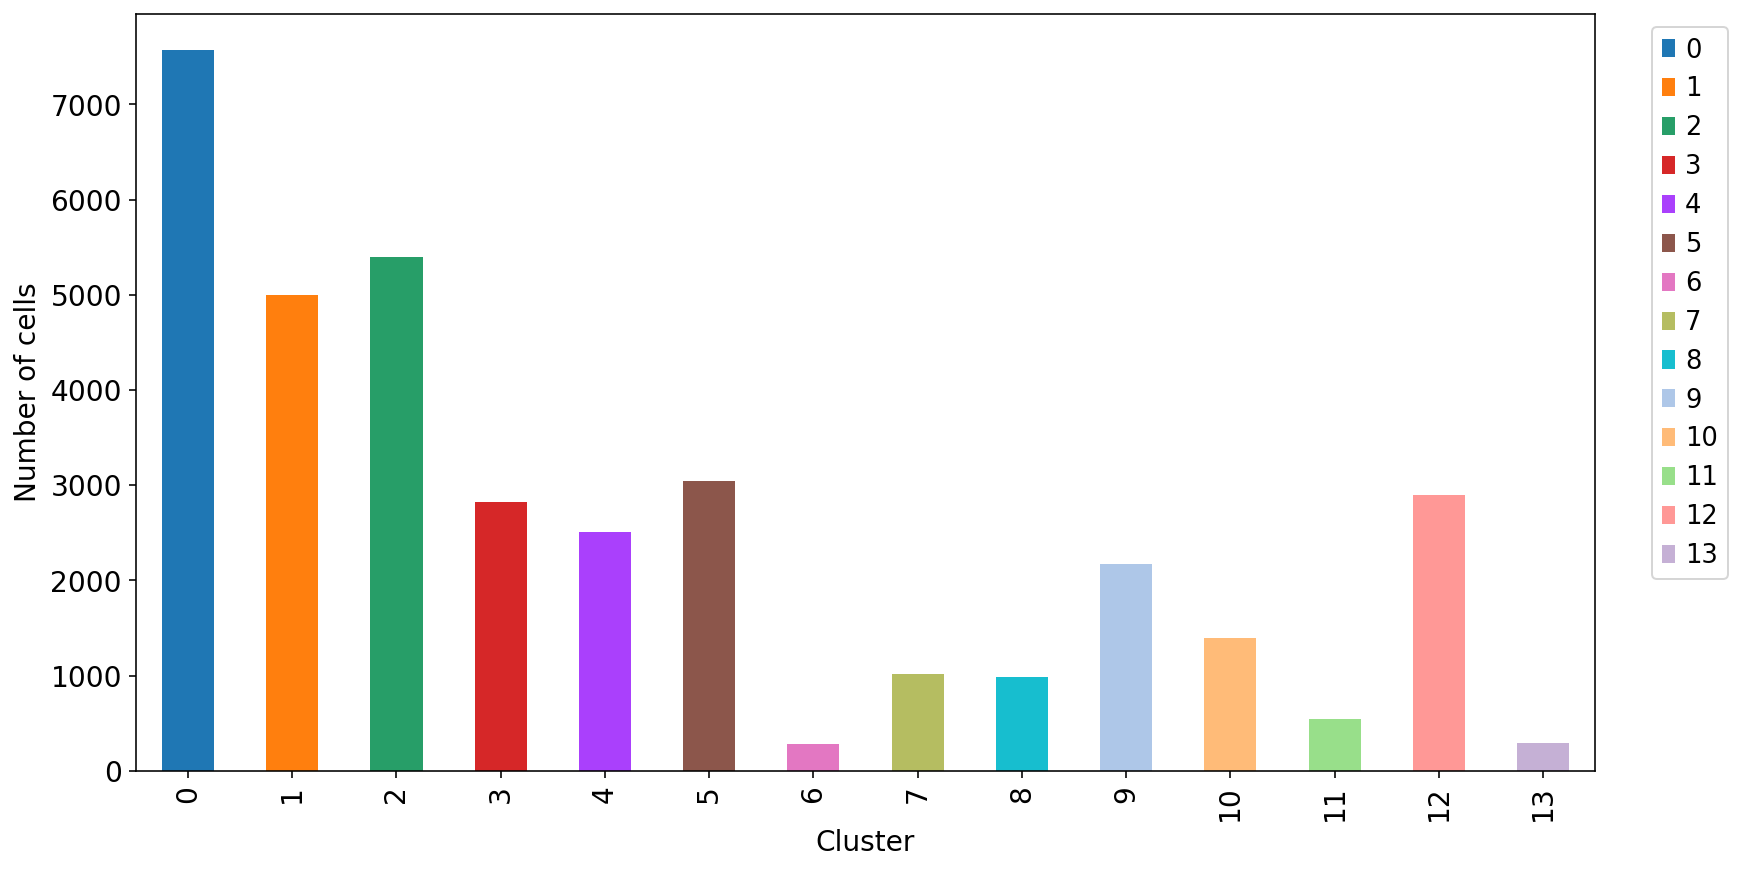

In [23]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["desc_0.5"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Plot Cluster Fraction stacked by Mouse ID

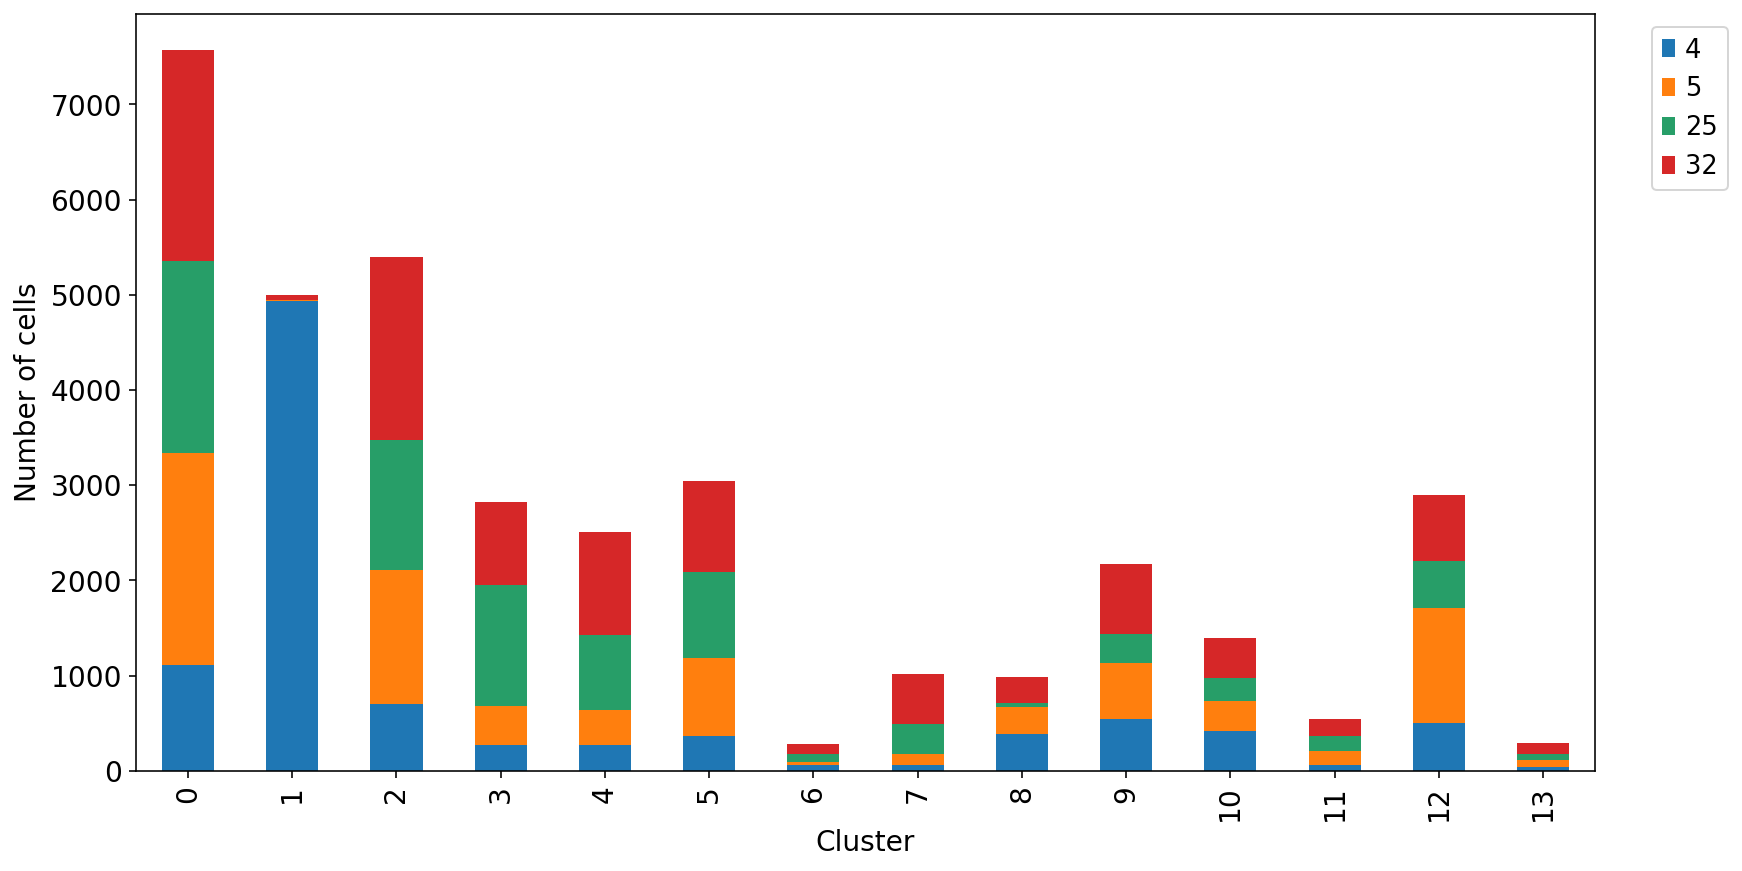

In [24]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["MouseID"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Plot Cluster Fraction stacked by Mouse ID Normalized

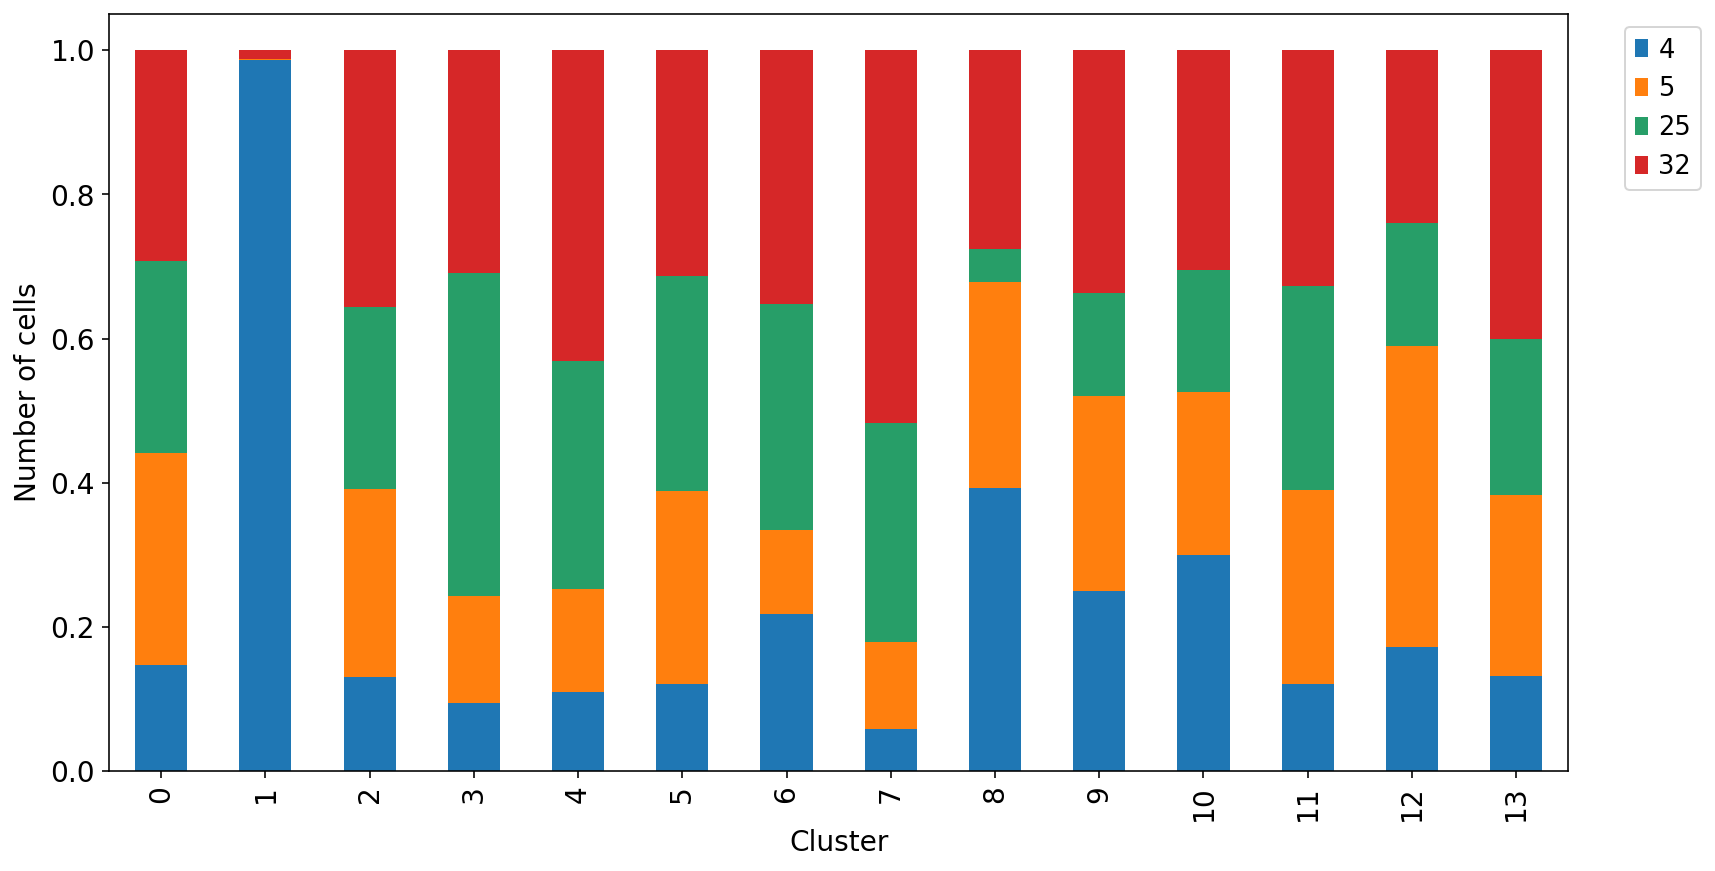

In [25]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["MouseID"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Plot Cluster Fraction stacked by Treatment

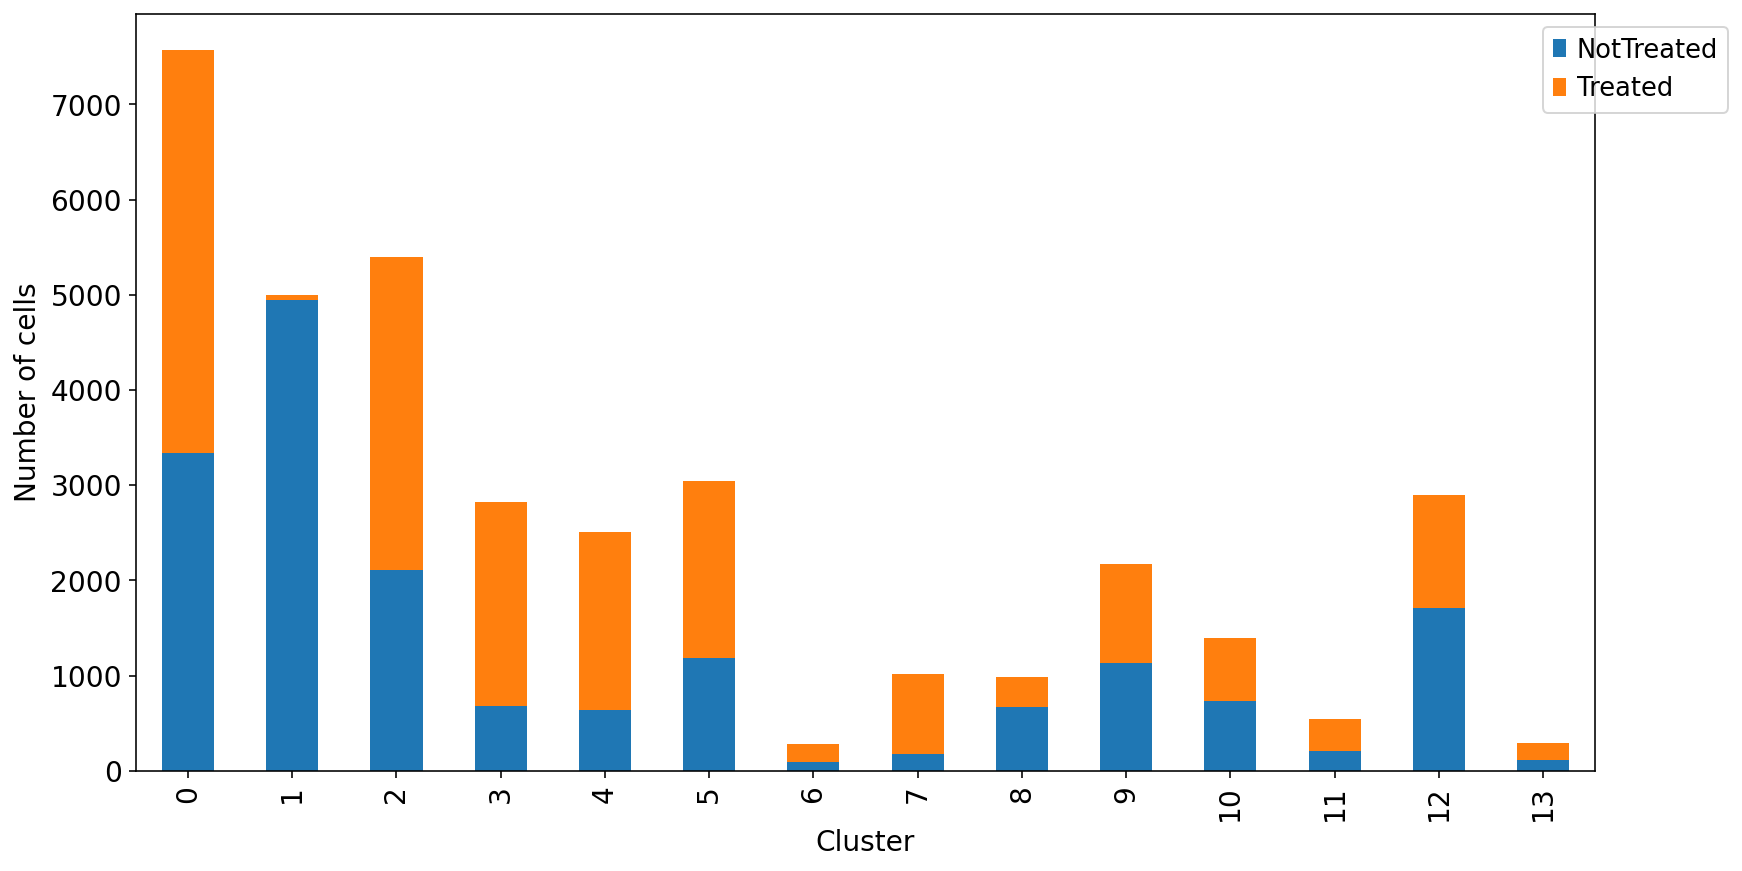

In [26]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["Treatment"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Plot Cluster Fraction stacked by Treatment ID

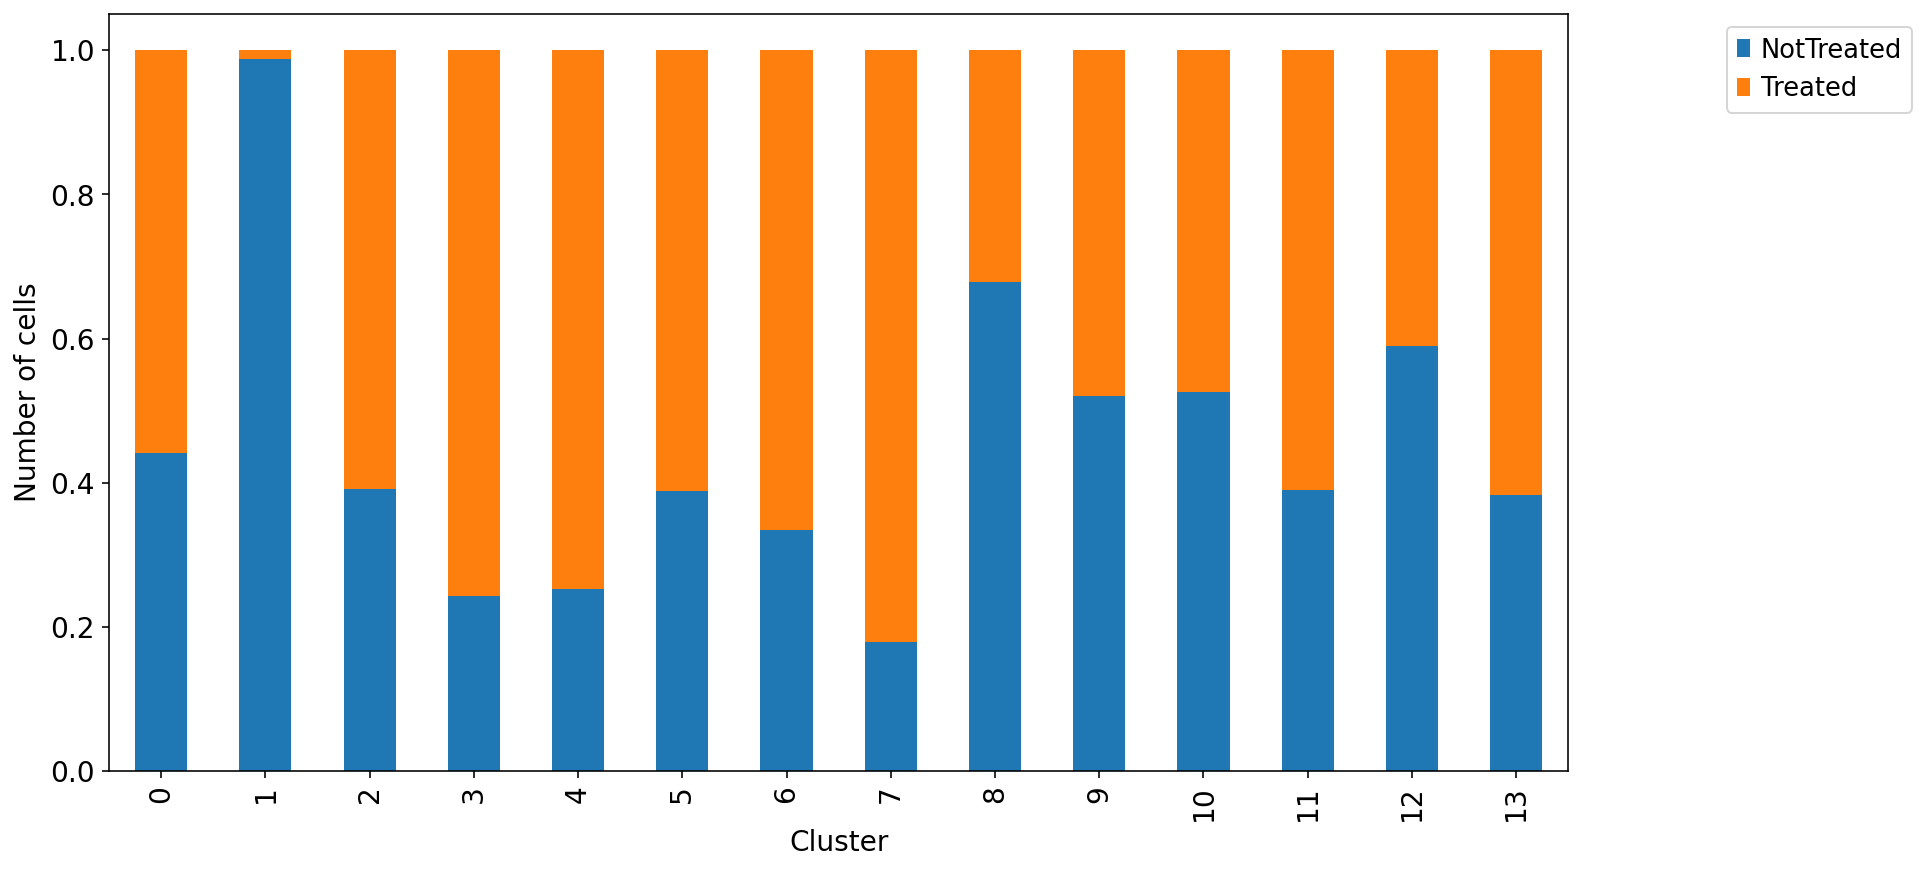

In [27]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["Treatment"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Fraction Mouse ID Unstacked

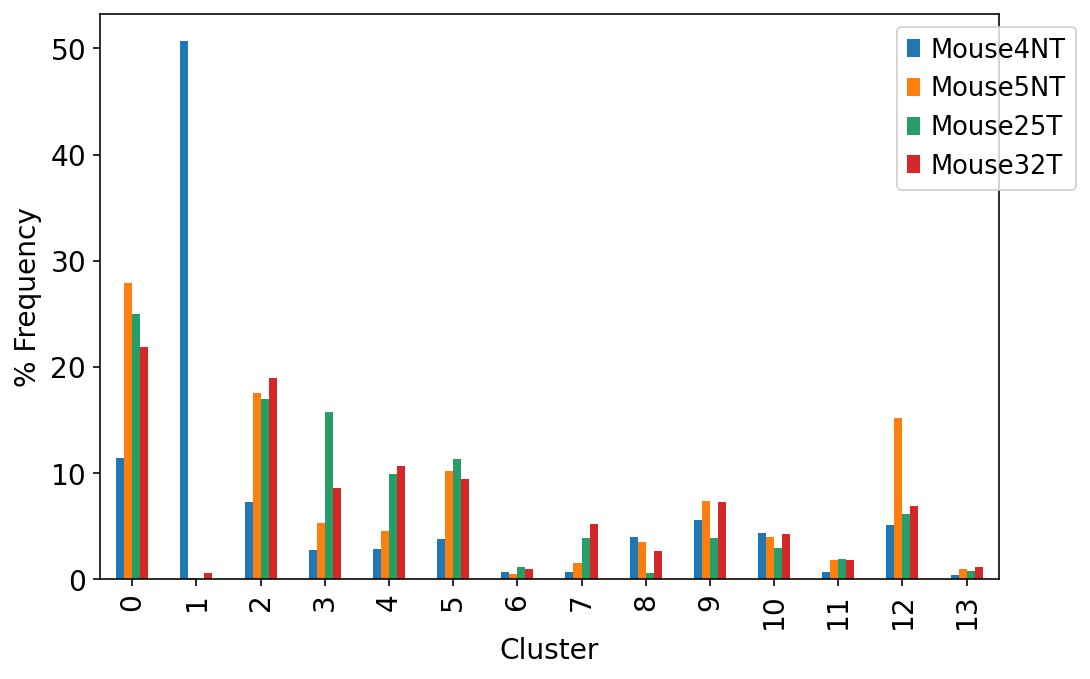

In [28]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.SampleID,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Fraction Treatment Unstacked

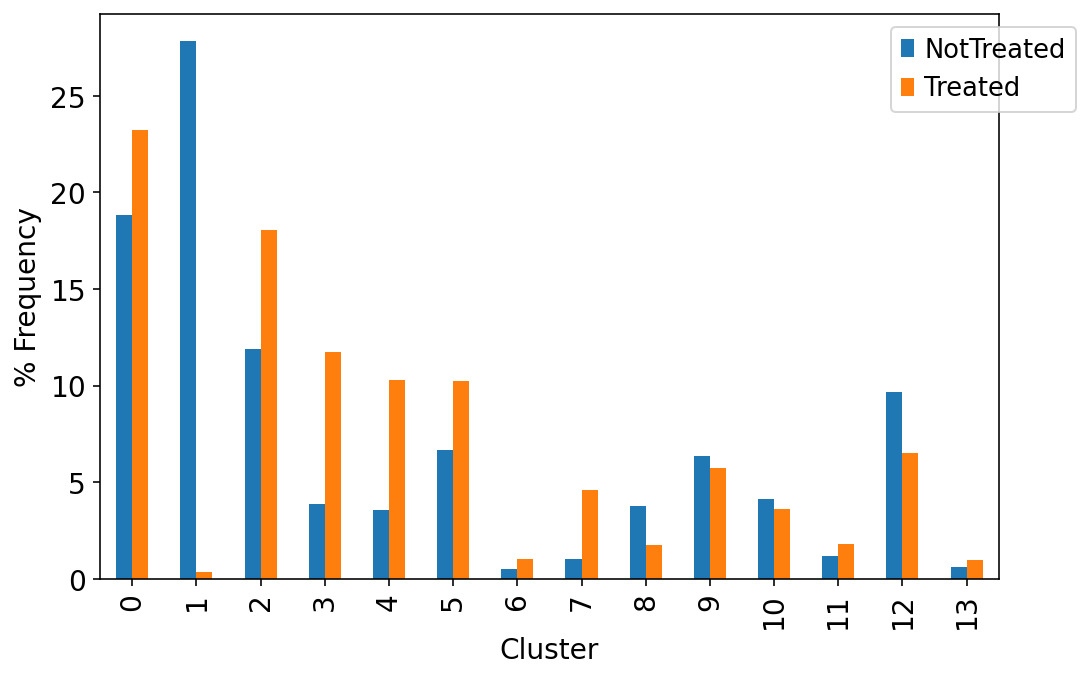

In [29]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.Treatment,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

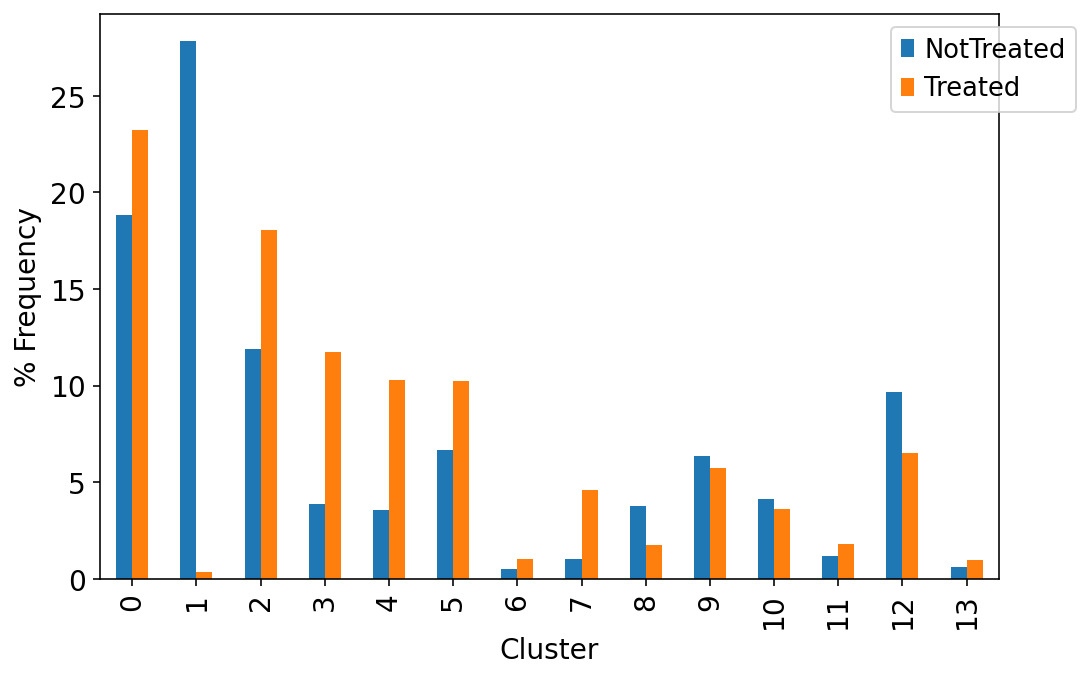

In [30]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.Treatment,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))


# Degs 

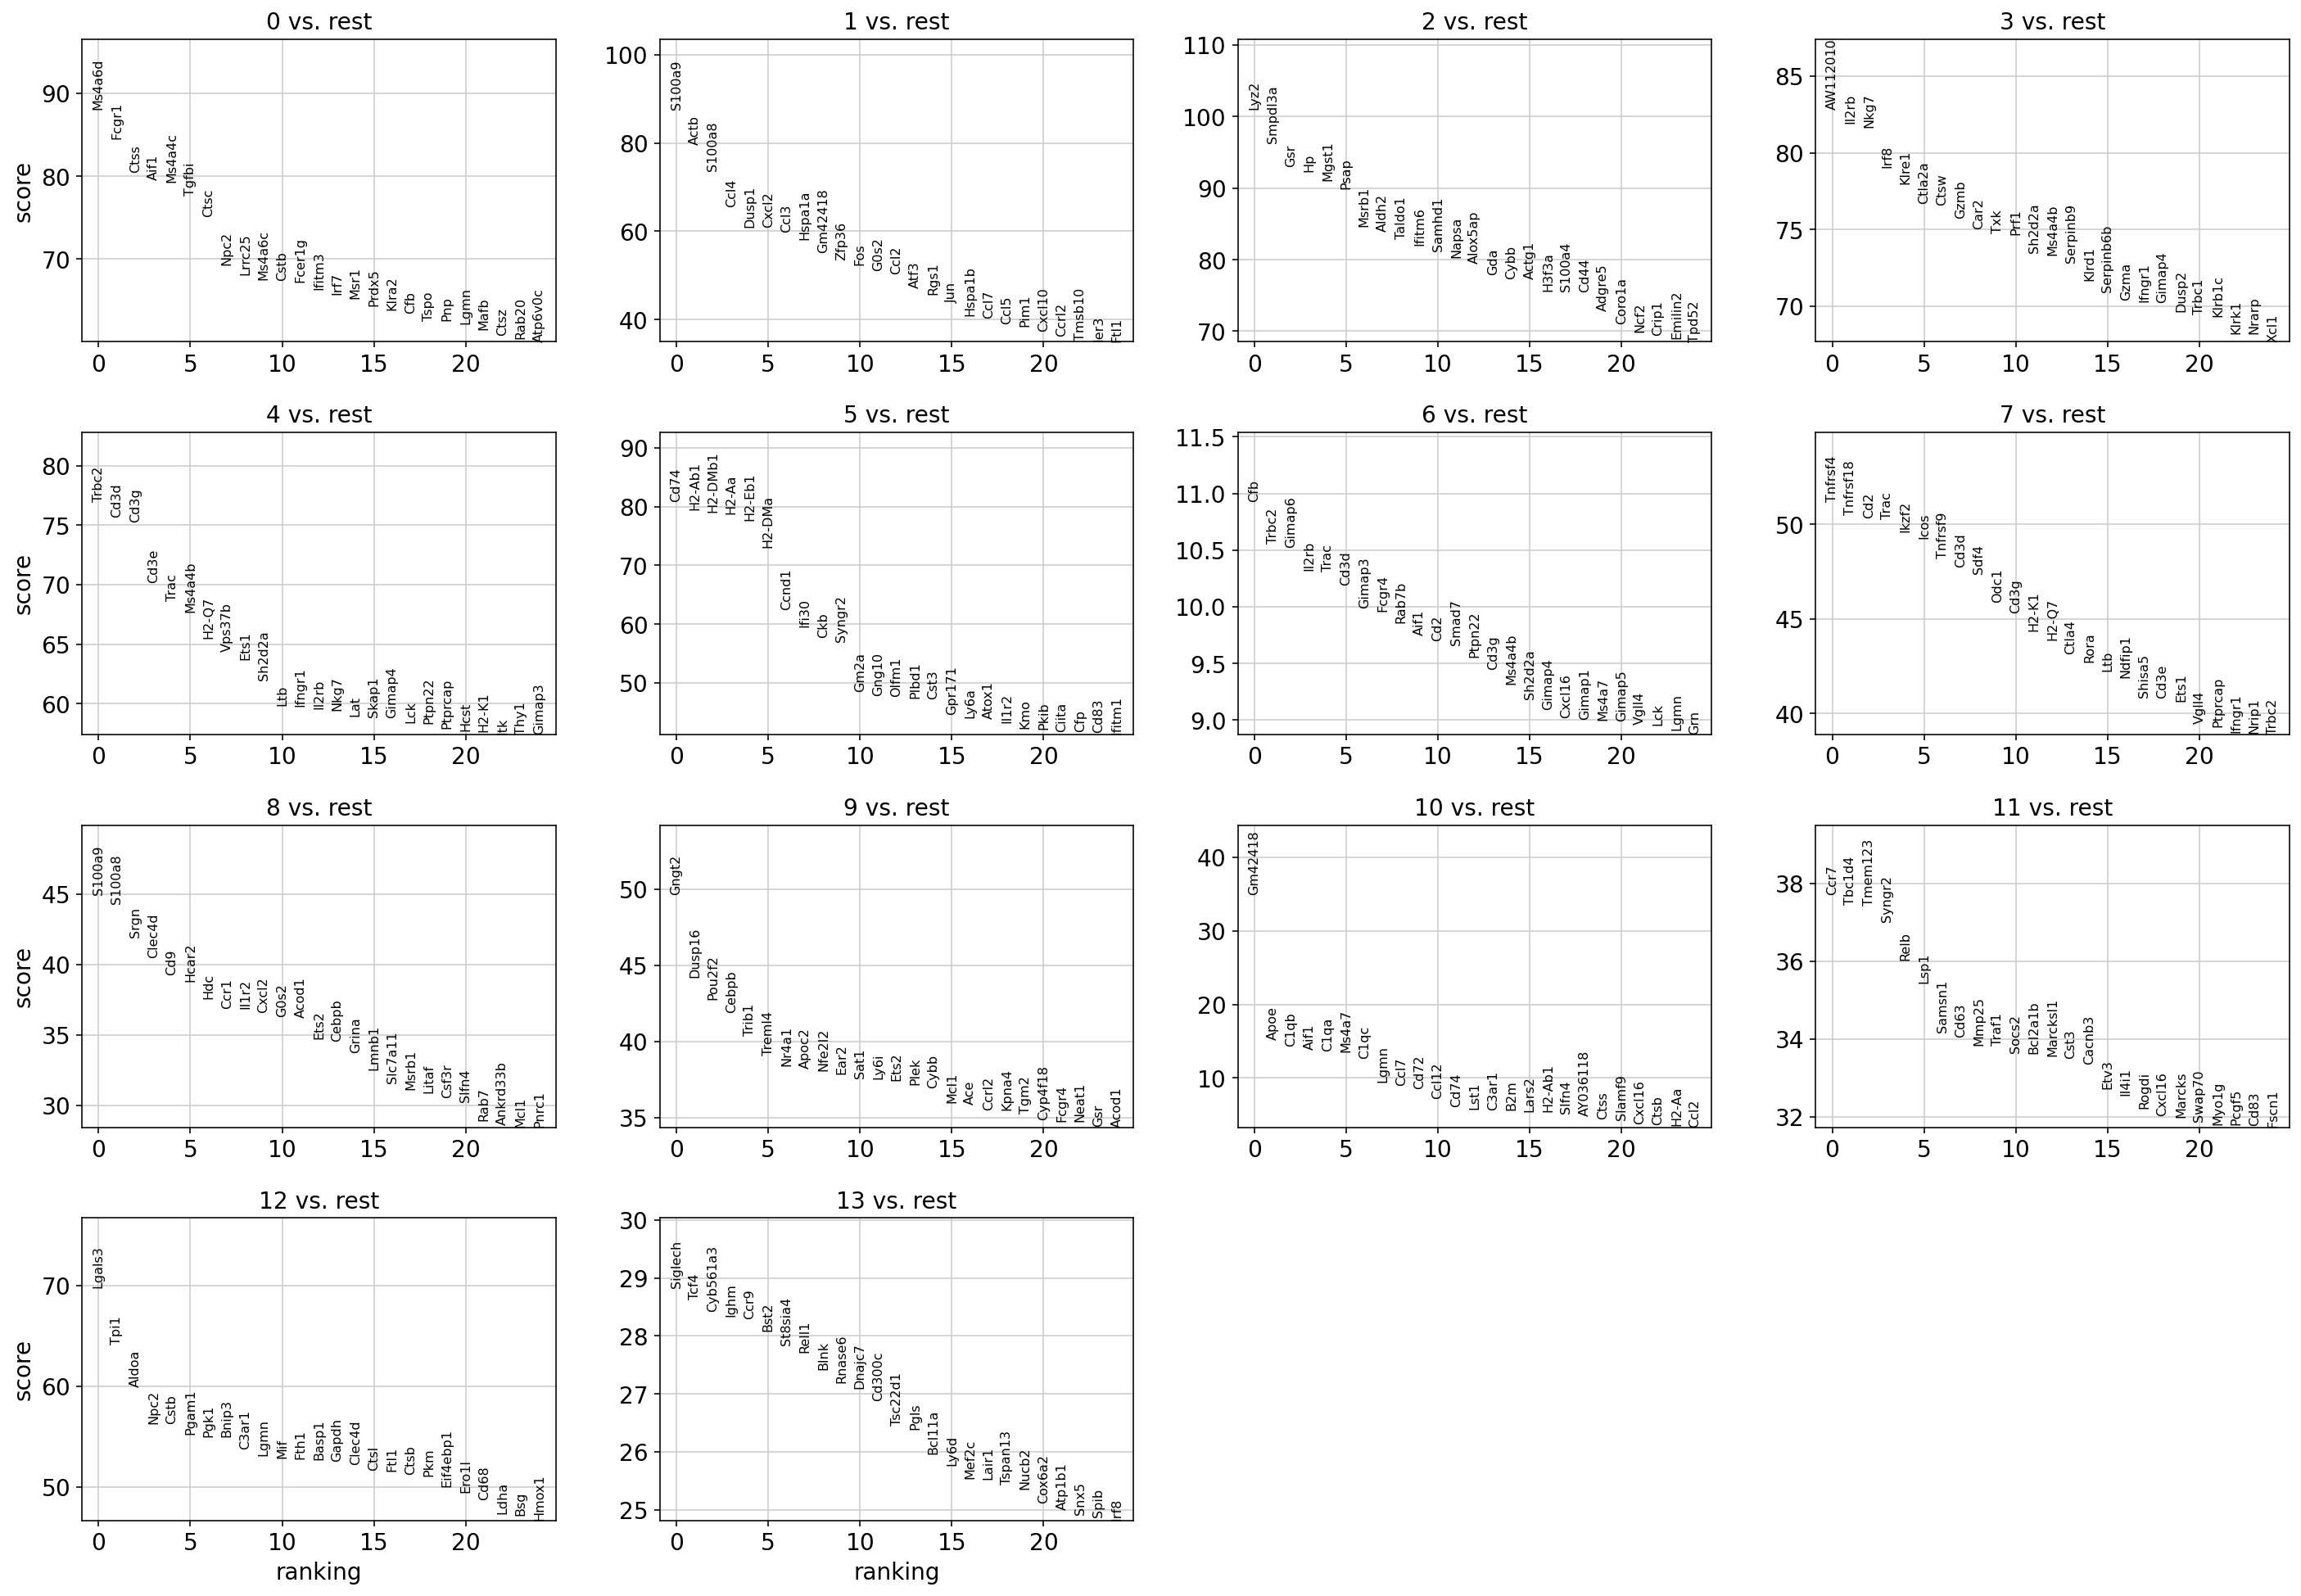

In [31]:
sc.tl.rank_genes_groups(adata, 'desc_0.5', method='wilcoxon',pts=0.2,layer='log1p',use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
result = adata.uns['rank_genes_groups']

# Export Excel

In [33]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Res05_Clusters_DEGS.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_], key='rank_genes_groups').to_excel(writer, sheet_name=groups[_],index=False)

In [34]:
import cytocipher as cc

In [36]:
adata.X = adata.layers['log1p']

Added data.uns['desc_0.5_markers']
Added data.obsm['desc_0.5_enrich_scores']


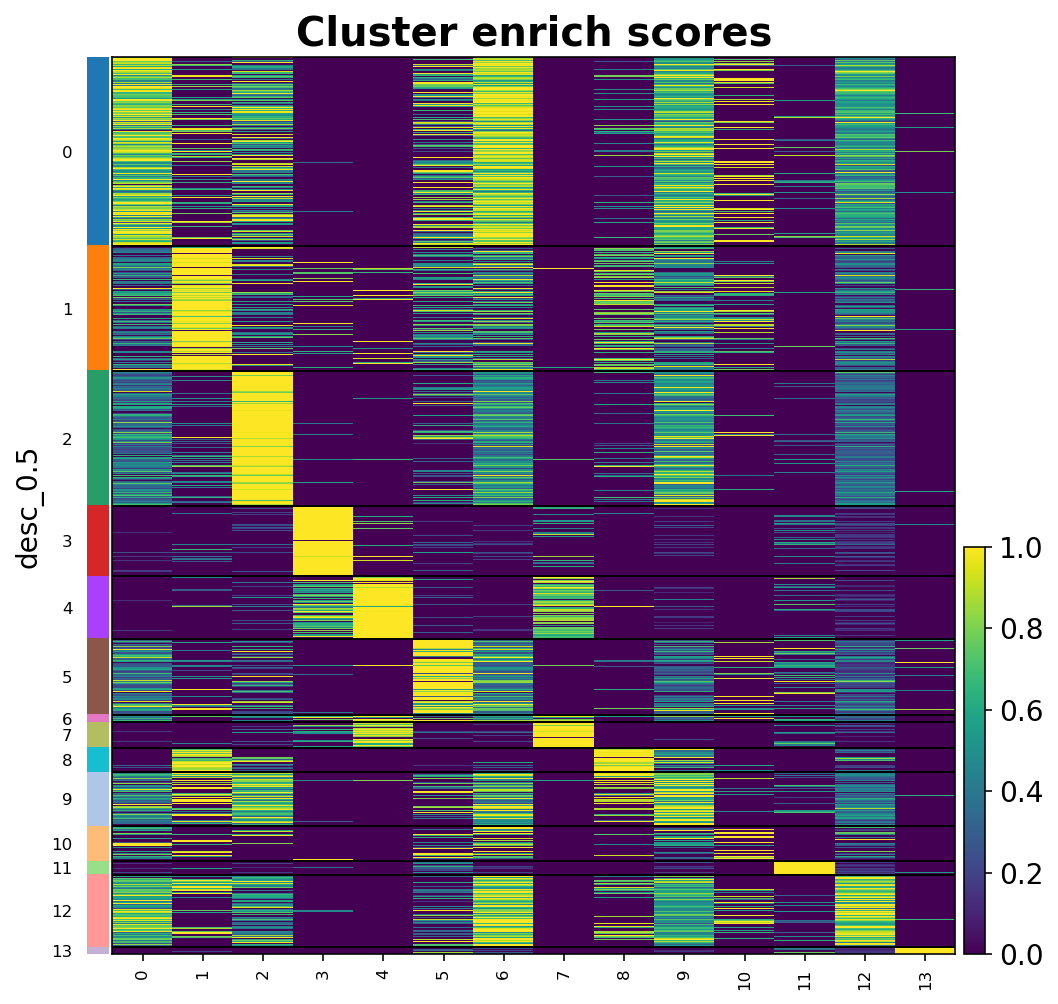

In [37]:
cc.tl.get_markers(adata, 'desc_0.5')
cc.tl.code_enrich(adata, 'desc_0.5')
cc.pl.enrich_heatmap(adata, 'desc_0.5',n_clust_cells=None)

# Split Object

In [38]:
C0 = adata[adata.obs['desc_0.5'].isin([0]),:]
C1 = adata[adata.obs['desc_0.5'].isin([1]),:]
C2 = adata[adata.obs['desc_0.5'].isin([2]),:]
C3 = adata[adata.obs['desc_0.5'].isin([3]),:]
C4 = adata[adata.obs['desc_0.5'].isin([4]),:]
C5 = adata[adata.obs['desc_0.5'].isin([5]),:]
C6 = adata[adata.obs['desc_0.5'].isin([6]),:]
C7 = adata[adata.obs['desc_0.5'].isin([7]),:]
C8 = adata[adata.obs['desc_0.5'].isin([8]),:]
C9 = adata[adata.obs['desc_0.5'].isin([9]),:]
C10 = adata[adata.obs['desc_0.5'].isin([10]),:]
C11 = adata[adata.obs['desc_0.5'].isin([11]),:]
C12 = adata[adata.obs['desc_0.5'].isin([12]),:]
C13 = adata[adata.obs['desc_0.5'].isin([13]),:]

# Degs Splitted by Treatment

In [39]:
sc.tl.rank_genes_groups(adata=C0,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C1,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C2,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C3,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C4,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C5,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C6,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C7,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C8,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C9,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C10,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C11,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C12,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')
sc.tl.rank_genes_groups(adata=C13,groupby='Treatment',groups=['Treated'],reference='NotTreated',use_raw=False,
                        method='wilcoxon',key_added="TreatedVSNotTreated",pts=0.2,layer='log1p')

In [40]:
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Res05_Clusters_DEGS_Treatment.xlsx') as writer:
    sc.get.rank_genes_groups_df(C0, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C0_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C1, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C1_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C2, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C2_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C3, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C3_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C4, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C4_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C5, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C5_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C6, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C6_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C7, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C7_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C8, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C8_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C9, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C9_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C10, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C10_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C11, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C11_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C12, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C12_TreatedVSNotTreated',index=False)
    sc.get.rank_genes_groups_df(C13, group='Treated',
                                key='TreatedVSNotTreated').to_excel(writer, sheet_name='C13_TreatedVSNotTreated',index=False)

# Dendrogram

In [41]:
sc.tl.dendrogram(adata, 'desc_0.5')

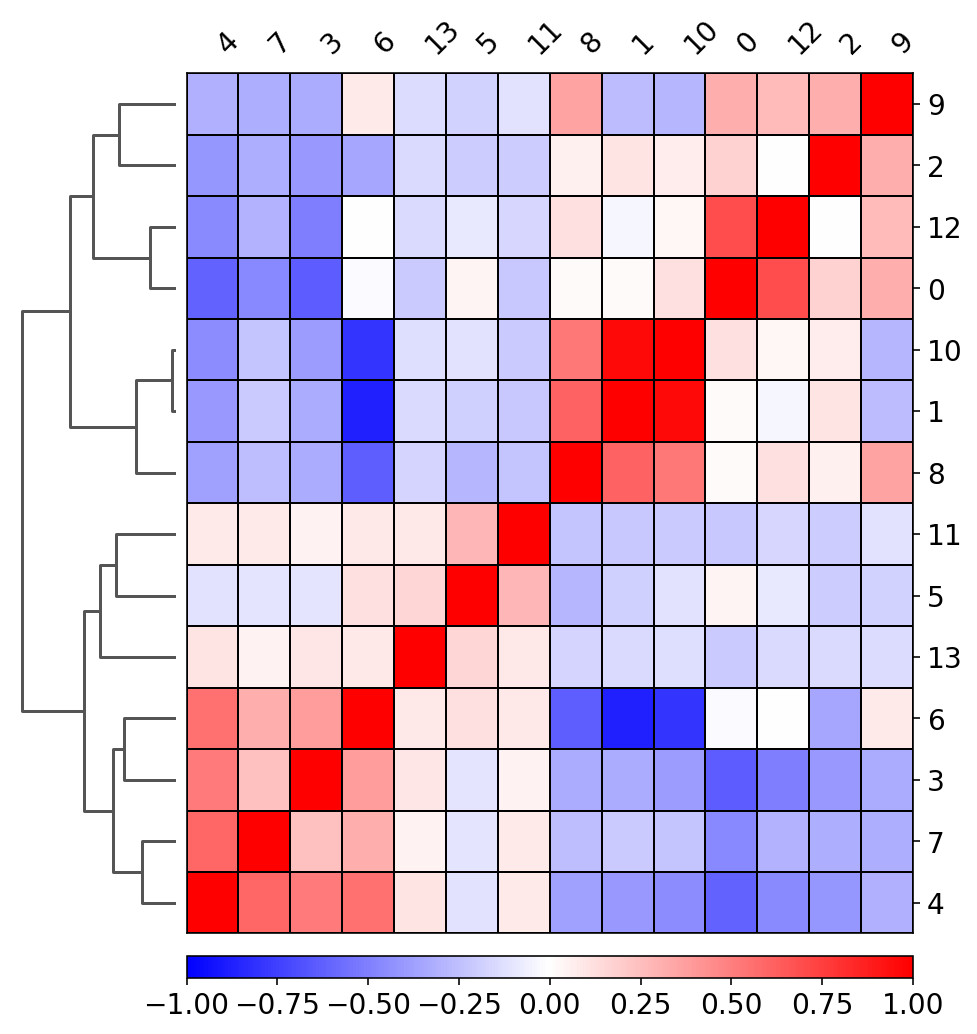

In [42]:
ax = sc.pl.correlation_matrix(adata, 'desc_0.5', figsize=(8,8))

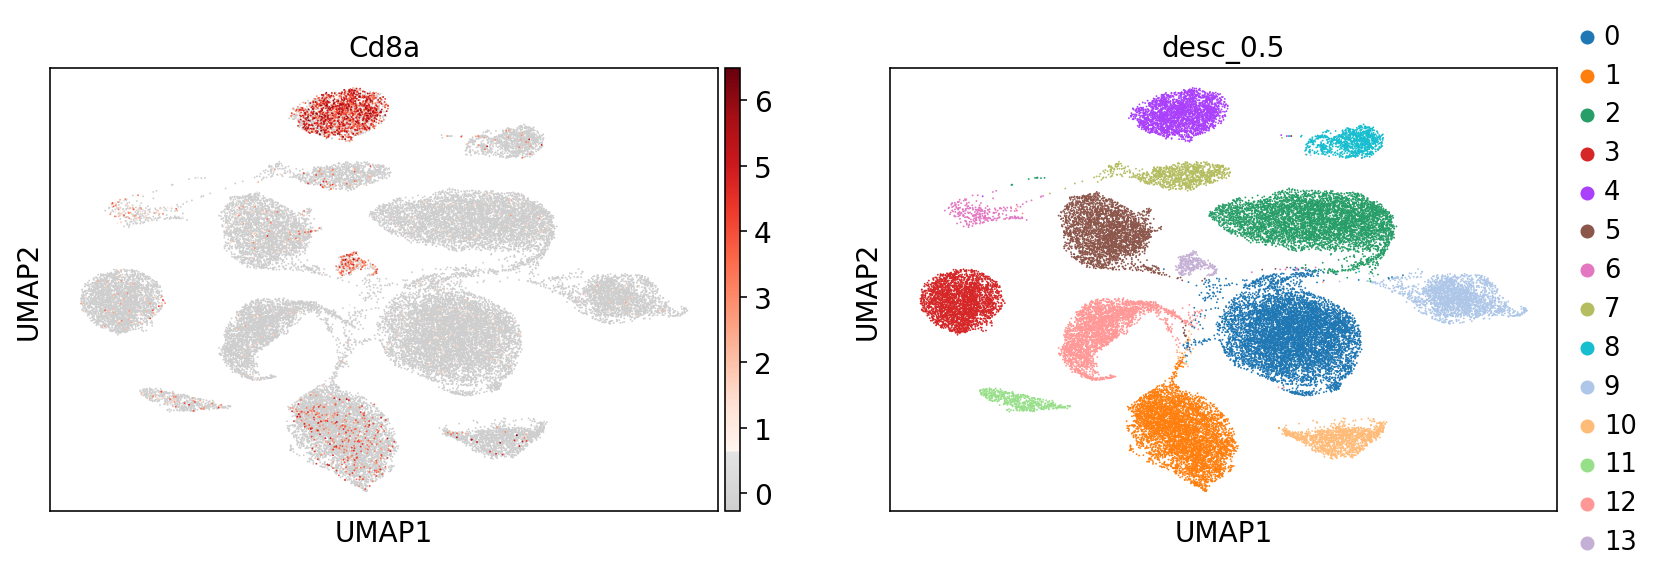

In [43]:
sc.pl.umap(adata, color=['Cd8a','desc_0.5'],color_map=mymap,layer='scaled')

In [44]:
adataCD8 = adata[adata.obs['desc_0.5'].isin([4]),:]

In [45]:
adataCD8.X = adataCD8.layers['raw_counts']

In [46]:
tmp = sc.AnnData(adataCD8.X)

In [47]:
tmp.layers['log1p'] = adataCD8.layers['log1p']

In [48]:
tmp.obs = adataCD8.obs

In [49]:
tmp.obsp = adataCD8.obsp

In [50]:
tmp.obsm =  adataCD8.obsm

In [51]:
tmp.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/CD8_pyscenic.h5ad")

In [52]:
del adata.uns

In [53]:
adata.X = adata.layers['raw_counts']

In [55]:
tmp = sc.AnnData(adata.X)

In [56]:
tmp.layers['log1p'] = adata.layers['log1p']

In [58]:
tmp.obs = adata.obs

In [59]:
tmp.obsp = adata.obsp

In [60]:
tmp.obsm =  adata.obsm

In [61]:
tmp.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Adata_Part3.h5ad")